# SET UP

In [ ]:
# ALL IMPORTS

import json
import os
from collections import defaultdict

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch

import matplotlib.pyplot as plt
import numpy as np

import cv2
from torch.utils.data import DataLoader

# mount our Google Drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# unzip images in Google Drive

!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred.zip' -d '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD'

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD'
annotation_dir = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/annotations.json'

with open(annotation_dir, "r") as f:
            annotations = json.load(f)

# CONVERTING ANNOTATIONS TO FEN

In [ ]:
# IMPORTANT

image_id_to_path = {img['id']: os.path.join(data_dir, img['path']) for img in annotations['images']}
print(image_id_to_path)

image_to_pieces = defaultdict(list)
for ann in annotations['annotations']['pieces']:
    image_to_pieces[ann['image_id']].append(ann)
print(image_to_pieces[0])

print(image_id_to_path[103])

print(image_to_pieces[8000])

In [ ]:
# IMPORTANT
# uppercase is white, lowercase is black
id_to_piece = {
    0: 'P', 1: 'R', 2: 'N', 3: 'B', 4: 'Q', 5: 'K',
    6: 'p', 7: 'r', 8: 'n', 9: 'b', 10: 'q', 11: 'k',
    12: '1'  # empty
}

piece_to_label = {
    'P': 0, 'R': 1, 'N': 2, 'B': 3, 'Q': 4, 'K': 5,
    'p': 6, 'r': 7, 'n': 8, 'b': 9, 'q': 10, 'k': 11
}

def fen_to_label_vector(fen, empty_char='0'):
    squares = []
    for row in fen.split('/'):
        for ch in row:
            if ch == empty_char:
                squares.append(12)
            elif ch.isdigit():
                squares.extend([12] * int(ch))  # for compressed digits like 8
            else:
                squares.append(piece_to_label[ch])
    assert len(squares) == 64, f"Expected 64 squares but got {len(squares)} in FEN: {fen}"
    return torch.tensor(squares, dtype=torch.long)

# convert image piece list to FEN
def pieces_to_fen(piece_list):
    board = [['1'] * 8 for _ in range(8)]
    pos_to_index = lambda pos: (8 - int(pos[1]), ord(pos[0]) - ord('a'))

    for piece in piece_list:
        row, col = pos_to_index(piece['chessboard_position'])
        board[row][col] = id_to_piece[piece['category_id']]

    fen_rows = []
    for row in board:
        fen_row = ''
        count = 0
        for cell in row:
            if cell == '1':
                fen_row += '0'
            else:
                fen_row += cell
        fen_rows.append(fen_row)

    return '/'.join(fen_rows)
def label_vector_to_fen(label_vector):
    """
    Converts a length-64 label vector into a FEN string.
    Assumes label 12 is empty.
    """
    assert len(label_vector) == 64, f"Expected 64 squares, got {len(label_vector)}"

    fen_rows = []
    for i in range(0, 64, 8):
        row = label_vector[i:i+8]
        fen_row = ''
        empty_count = 0

        for val in row:
            if val == 12:  # empty square
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += id_to_piece[int(val)]

        if empty_count > 0:
            fen_row += str(empty_count)

        fen_rows.append(fen_row)

    return '/'.join(fen_rows)

print(pieces_to_fen(image_to_pieces[2384]))
print(fen_to_label_vector(pieces_to_fen(image_to_pieces[10])))
print(fen_to_label_vector(pieces_to_fen(image_to_pieces[10])).shape)

# DATASET

In [ ]:
class ChessboardRotDataset(Dataset):
    def __init__(self, image_paths, fen_labels, transform=None):
        self.image_paths = image_paths
        self.fen_labels = fen_labels
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      img_path = self.image_paths[idx]
      fen = self.fen_labels[idx]

      image = Image.open(img_path).convert('RGB')
      image_tensor = self.transform(image)

      try:
          rotations = [
              fen_to_label_vector(fen),
              fen_to_label_vector(rotate_fen_90(fen)),
              fen_to_label_vector(rotate_fen_180(fen)),
              fen_to_label_vector(rotate_fen_270(fen)),
          ]
      except AssertionError as e:
          print(f"Bad FEN at index {idx}:\n{fen}")
          raise e

      return image_tensor, rotations

## TRAIN LOADER

In [ ]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred_hough.pkl", 'rb') as f:
    X_loaded, y_loaded = pickle.load(f)
# print(X_loaded)
# print(y_loaded)
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(256, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])
def custom_collate(batch):
    images, label_sets = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, label_sets  # label_sets is a list of B lists of 4 tensors

# Recreate Dataset and DataLoader
train_dataset = ChessboardRotDataset(X_loaded, y_loaded, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)

print(f"Total images: {len(train_dataset)}")

total images: 5325

## VAL LOADER

In [ ]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred_hough_val.pkl", 'rb') as f:
    X_loaded, y_loaded = pickle.load(f)
print(X_loaded)
print(y_loaded)
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Recreate Dataset and DataLoader
val_dataset = ChessboardRotDataset(X_loaded, y_loaded, transform=data_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
print(f"Total images: {len(val_dataset)}")

Total images: 1835


## TEST LOADER (uses diff class)

In [ ]:
import pickle
class ChessboardRotDatasetTEST(Dataset):
    def __init__(self, image_paths, fen_labels, transform=None):
        self.image_paths = image_paths
        self.fen_labels = fen_labels
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      img_path = self.image_paths[idx]
      fen = self.fen_labels[idx]

      image = Image.open(img_path).convert('RGB')
      image_tensor = self.transform(image)

      try:
          rotations = [
              fen_to_label_vector(fen),
              fen_to_label_vector(rotate_fen_90(fen)),
              fen_to_label_vector(rotate_fen_180(fen)),
              fen_to_label_vector(rotate_fen_270(fen)),
          ]
      except AssertionError as e:
          print(f"Bad FEN at index {idx}:\n{fen}")
          raise e
      image_path = self.image_paths[idx]

      return image_tensor, rotations, image_path
with open("/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred_hough_test.pkl", 'rb') as f:
    X_loaded, y_loaded = pickle.load(f)
print(X_loaded)
print(y_loaded)
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
def custom_collateTEST(batch):
    images, label_sets, paths = zip(*batch)  # Now unpack 3 values
    images = torch.stack(images, dim=0)
    return images, label_sets, paths
# def custom_collate(batch):
#     # Unpack only the first two values: image_tensor and rotations
#     images, label_sets, _ = zip(*batch)  # Ignore paths
#     images = torch.stack(images, dim=0)
#     return images, label_sets


# Recreate Dataset and DataLoader
test_dataset = ChessboardRotDatasetTEST(X_loaded, y_loaded, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=custom_collateTEST)
print(f"Total images: {len(test_dataset)}")

test_dataset_plain = ChessboardRotDataset(X_loaded, y_loaded, transform=data_transform)
test_loader_plain = DataLoader(test_dataset_plain, batch_size=16, shuffle=True, collate_fn=custom_collate)
print(f"Total images: {len(test_dataset_plain)}")


Total images: 1790

Total images: 1790

# TRAIN FUNCTION

In [ ]:
def train(
    model, dataloader, device, epochs=15,
    save_model=True, save_dir=None,
    plot_loss=True, lr=1e-4, weight_decay=1e-5,
    empty_class_idx=12, empty_class_weight=0.3,
    val_loader=None  # <- added
):
    import matplotlib.pyplot as plt

    model = model.to(device)

    weights = torch.ones(13)
    weights[empty_class_idx] = empty_class_weight
    weights = weights.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    epoch_train_losses = []
    epoch_train_acc_all = []
    epoch_train_acc_no_empty = []

    epoch_val_losses = []
    epoch_val_acc_all = []
    epoch_val_acc_no_empty = []

    if save_model:
        assert save_dir is not None, "Please provide a save_dir to save model checkpoints."
        os.makedirs(save_dir, exist_ok=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_all = 0
        correct_non_empty = 0
        total_all = 0
        total_non_empty = 0

        for images, label_rotations in dataloader:
            images = images.to(device)
            label_rotations = [[lbl.to(device) for lbl in rotations] for rotations in label_rotations]

            optimizer.zero_grad()
            outputs = model(images)  # (B, 64, 13)

            losses = []
            matched_labels = []
            for i in range(images.size(0)):
                sample_losses = [F.cross_entropy(outputs[i], lbl, weight=weights, ignore_index=-1) for lbl in label_rotations[i]]
                best_idx = torch.argmin(torch.stack(sample_losses))
                losses.append(sample_losses[best_idx])
                matched_labels.append(label_rotations[i][best_idx])
            loss = torch.stack(losses).mean()
            matched_labels = torch.stack(matched_labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = outputs.argmax(dim=2)
            mask = matched_labels != empty_class_idx
            correct_all += (preds == matched_labels).sum().item()
            total_all += matched_labels.numel()
            correct_non_empty += ((preds == matched_labels) & mask).sum().item()
            total_non_empty += mask.sum().item()

        avg_train_loss = running_loss / len(dataloader)
        acc_all = correct_all / total_all if total_all > 0 else 0.0
        acc_no_empty = correct_non_empty / total_non_empty if total_non_empty > 0 else 0.0

        epoch_train_losses.append(avg_train_loss)
        epoch_train_acc_all.append(acc_all)
        epoch_train_acc_no_empty.append(acc_no_empty)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f} | Acc (all): {acc_all:.4f} | Acc (non-empty): {acc_no_empty:.4f}")

        if save_model:
            save_path = os.path.join(save_dir, f"epoch{epoch+1}.pth")
            torch.save(model.state_dict(), save_path)
            print(f"✅ Model saved to: {save_path}")

        # --- Evaluate on validation set (if provided) ---
        if val_loader is not None:
            val_loss, val_acc_all, val_acc_no_empty, _ = evaluate_rotation_invariant(model, val_loader, device=device)
            epoch_val_losses.append(val_loss)
            epoch_val_acc_all.append(val_acc_all)
            epoch_val_acc_no_empty.append(val_acc_no_empty)

    # --- Plotting ---
    if plot_loss:
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epoch_train_losses, label='Train Loss')
        if val_loader is not None:
            plt.plot(epoch_val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epoch_train_acc_all, label='Train Acc (All)')
        plt.plot(epoch_train_acc_no_empty, label='Train Acc (Non-Empty)')
        if val_loader is not None:
            plt.plot(epoch_val_acc_all, label='Val Acc (All)')
            plt.plot(epoch_val_acc_no_empty, label='Val Acc (Non-Empty)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.legend()

        plt.tight_layout()
        plt.show()

# EVAL FUNCTION (SIMPLE)

In [ ]:
def evaluate_rotation_invariant(model, dataloader, device, empty_class_idx=12):
    import collections

    model.eval()
    total_loss = 0.0
    correct_all = 0
    correct_non_empty = 0
    total_all = 0
    total_non_empty = 0
    board_error_hist = collections.Counter()

    pbar = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for images, label_rotations in pbar:
            images = images.to(device)
            label_rotations = [[lbl.to(device) for lbl in rots] for rots in label_rotations]

            outputs = model(images)

            matched_labels = []
            for i in range(outputs.size(0)):
                losses = [F.cross_entropy(outputs[i], lbl) for lbl in label_rotations[i]]
                min_idx = torch.argmin(torch.stack(losses))
                total_loss += losses[min_idx].item()
                matched_labels.append(label_rotations[i][min_idx])

            preds = outputs.argmax(dim=2)
            matched_labels_tensor = torch.stack(matched_labels)

            mask = matched_labels_tensor != empty_class_idx
            correct_all += (preds == matched_labels_tensor).sum().item()
            total_all += matched_labels_tensor.numel()
            correct_non_empty += ((preds == matched_labels_tensor) & mask).sum().item()
            total_non_empty += mask.sum().item()

            acc = correct_all / total_all if total_all > 0 else 0.0
            pbar.set_postfix(acc=f"{acc:.2%}")

            batch_errors = (preds != matched_labels_tensor).sum(dim=1)
            for err in batch_errors.cpu().tolist():
                board_error_hist[err] += 1

    avg_loss = total_loss / len(dataloader)
    acc_all = correct_all / total_all if total_all > 0 else 0.0
    acc_non_empty = correct_non_empty / total_non_empty if total_non_empty > 0 else 0.0

    print(f"\n📊 Validation Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy (all squares): {acc_all:.4f}")
    print(f"♟️ Accuracy (non-empty squares only): {acc_non_empty:.4f}")
    print("\n🧮 Board-level prediction accuracy (errors per board):")
    for k in sorted(board_error_hist):
        print(f"  Boards with {k:2d} wrong squares: {board_error_hist[k]}")

    return avg_loss, acc_all, acc_non_empty, board_error_hist


# EVAL FUNCTION (VISUALIZE)

In [ ]:
from tqdm.notebook import tqdm
def evaluate_rotation_invariant_visuals(model, dataloader, device, empty_class_idx=12, image_paths=None, label_to_fen=None):
    import collections
    import matplotlib.pyplot as plt
    import cv2

    model.eval()
    total_loss = 0.0
    correct_all = 0
    correct_non_empty = 0
    total_all = 0
    total_non_empty = 0
    board_error_hist = collections.Counter()

    pbar = tqdm(dataloader, desc="Evaluating", leave=False)
    example_idx = 0  # to track index for image_paths

    with torch.no_grad():
        for images, label_rotations, image_paths_batch in pbar:
            images = images.to(device)
            label_rotations = [[lbl.to(device) for lbl in rots] for rots in label_rotations]

            outputs = model(images)
            matched_labels = []
            for i in range(outputs.size(0)):
                losses = [F.cross_entropy(outputs[i], lbl) for lbl in label_rotations[i]]
                min_idx = torch.argmin(torch.stack(losses))
                total_loss += losses[min_idx].item()
                matched_labels.append(label_rotations[i][min_idx])

            preds = outputs.argmax(dim=2)
            matched_labels_tensor = torch.stack(matched_labels)

            mask = matched_labels_tensor != empty_class_idx
            correct_all += (preds == matched_labels_tensor).sum().item()
            total_all += matched_labels_tensor.numel()
            correct_non_empty += ((preds == matched_labels_tensor) & mask).sum().item()
            acc = correct_all / total_all if total_all > 0 else 0.0
            pbar.set_postfix(acc=f"{acc:.2%}")

            batch_errors = (preds != matched_labels_tensor).sum(dim=1)

            for i in range(len(batch_errors)):
                num_errors = batch_errors[i].item()
                board_error_hist[num_errors] += 1

                if num_errors == 0 and image_paths is not None and label_to_fen is not None:
                    image_path = image_paths_batch[i]

                    img = cv2.imread(image_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    gt_fen = label_to_fen(matched_labels_tensor[i].cpu())
                    pred_fen = label_to_fen(preds[i].cpu())

                    # --- Plot image with FENs ---
                    plt.figure(figsize=(6, 6))
                    plt.imshow(img)
                    plt.axis("off")
                    plt.title("✅ Correct Prediction")
                    plt.figtext(0.5, -0.1, f"GT FEN:   {gt_fen}\nPred FEN: {pred_fen}",
                                wrap=True, horizontalalignment='center', fontsize=10)
                    plt.tight_layout()
                    plt.show()

                example_idx += 1

    avg_loss = total_loss / len(dataloader)
    acc_all = correct_all / total_all
    acc_non_empty = correct_non_empty / total_non_empty

    print(f"\n📊 Validation Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy (all squares): {acc_all:.4f}")
    print(f"♟️ Accuracy (non-empty squares only): {acc_non_empty:.4f}")
    print("\n🧮 Board-level prediction accuracy (errors per board):")
    for k in sorted(board_error_hist):
        print(f"  Boards with {k:2d} wrong squares: {board_error_hist[k]}")

    return avg_loss, acc_all, acc_non_empty, board_error_hist

# EVAL FUNCTION (STATS)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- minimal defaults so this runs standalone; override via args if you already have these ---
DEFAULT_ID_TO_PIECE = {
    0:'P',1:'R',2:'N',3:'B',4:'Q',5:'K', 6:'p',7:'r',8:'n',9:'b',10:'q',11:'k', 12:'1'
}

def _basic_legality_checks(pred_labels_64, id_to_piece=DEFAULT_ID_TO_PIECE):
    """
    Very light legality: 1 white king, 1 black king; no pawns on ranks 1/8; <=8 pawns/side.
    pred_labels_64: (64,) int tensor or array
    """
    arr = np.asarray(pred_labels_64, dtype=int)
    pieces = [id_to_piece[int(v)] for v in arr]
    # counts
    wK = sum(p=='K' for p in pieces)
    bK = sum(p=='k' for p in pieces)
    wP = sum(p=='P' for p in pieces)
    bP = sum(p=='p' for p in pieces)
    if wK != 1 or bK != 1:
        return False
    # pawn rank rule (ranks from top -> bottom in your labeling)
    top_rank   = pieces[:8]
    bottom_rank= pieces[-8:]
    if any(p=='P' for p in top_rank) or any(p=='P' for p in bottom_rank):
        return False
    if any(p=='p' for p in top_rank) or any(p=='p' for p in bottom_rank):
        return False
    if wP > 8 or bP > 8:
        return False
    return True

def _confusion_and_prf1(gt, pr, num_classes=13):
    """
    gt, pr: 1D int arrays of same length (over all squares)
    Returns: conf_mat (C,C), per-class precision/recall/f1, support
    """
    gt = np.asarray(gt, dtype=int)
    pr = np.asarray(pr, dtype=int)
    conf = np.zeros((num_classes, num_classes), dtype=np.int64)
    for g, p in zip(gt, pr):
        conf[g, p] += 1

    # per-class metrics
    eps = 1e-12
    tp = np.diag(conf)
    fp = conf.sum(axis=0) - tp
    fn = conf.sum(axis=1) - tp
    prec = tp / np.maximum(tp+fp, eps)
    rec  = tp / np.maximum(tp+fn, eps)
    f1   = 2*prec*rec / np.maximum(prec+rec, eps)
    support = conf.sum(axis=1)
    return conf, prec, rec, f1, support

def _ece_reliability(max_probs, correct, n_bins=15):
    """
    max_probs: (N,) float in [0,1]; correct: (N,) bool
    Returns: ece, (bin_conf, bin_acc, bin_count)
    """
    max_probs = np.asarray(max_probs)
    correct = np.asarray(correct).astype(np.float32)
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0.0
    bin_conf = []
    bin_acc  = []
    bin_count= []
    N = len(max_probs)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (max_probs > lo) & (max_probs <= hi) if i>0 else (max_probs >= lo) & (max_probs <= hi)
        cnt = mask.sum()
        if cnt == 0:
            bin_conf.append(np.nan)
            bin_acc.append(np.nan)
            bin_count.append(0)
            continue
        conf = max_probs[mask].mean()
        acc  = correct[mask].mean()
        ece += (cnt / N) * abs(acc - conf)
        bin_conf.append(conf); bin_acc.append(acc); bin_count.append(int(cnt))
    return float(ece), np.array(bin_conf), np.array(bin_acc), np.array(bin_count)

def evaluate_plus(
    model,
    dataloader,
    device,
    empty_class_idx=12,
    id_to_piece=DEFAULT_ID_TO_PIECE,
    compute_plots=True,
    title_prefix="Eval"
):
    """
    Rotation-invariant evaluation with rich metrics:
      - exact-board accuracy, error histogram + CDF, mean/median hamming
      - square acc (all / non-empty), top-2 acc
      - per-class precision/recall/F1, confusion matrix
      - calibration (ECE + reliability curve)
      - 8x8 correctness heatmap (avg over dataset), light/dark split
      - legality pass rate on predicted boards
      - rotation choice distribution (0°,90°,180°,270°)
    Returns: dict of metrics, plus (optionally) plots.
    """
    model.eval()
    total_loss = 0.0
    all_gt = []
    all_pr = []
    all_pr_top2_hits = []
    all_maxprob = []
    all_correct_flags = []

    board_errors = []
    rotation_picks = []  # which rotation idx chosen per board
    per_board_legality = []

    # 8x8 correctness heatmap sums
    heat_sum = np.zeros((8,8), dtype=np.float64)
    heat_cnt = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="evaluate_plus", leave=False)
        for batch in pbar:
            # dataloader returns (images, label_rotations) OR (images, label_rotations, paths)
            if len(batch) == 2:
                images, label_rotations = batch
            else:
                images, label_rotations, _ = batch

            images = images.to(device)
            label_rotations = [[lbl.to(device) for lbl in rots] for rots in label_rotations]

            outputs = model(images)  # (B, 64, 13)
            # softmax for probs
            probs = F.softmax(outputs, dim=2)
            max_prob, pred = probs.max(dim=2)  # (B,64)

            # top-2
            top2 = probs.topk(k=2, dim=2).indices  # (B,64,2)

            # choose best rotation per sample using CE loss
            B = outputs.size(0)
            matched_labels = []
            chosen_rot_idx = []
            losses = []
            for i in range(B):
                lossi = [F.cross_entropy(outputs[i], lbl) for lbl in label_rotations[i]]
                li = torch.stack(lossi)
                min_idx = int(torch.argmin(li).item())
                chosen_rot_idx.append(min_idx)
                losses.append(float(lossi[min_idx].item()))
                matched_labels.append(label_rotations[i][min_idx])

            total_loss += np.mean(losses)
            rotation_picks.extend(chosen_rot_idx)

            matched_labels = torch.stack(matched_labels)  # (B,64)
            # accumulate metrics
            gt_np = matched_labels.detach().cpu().numpy().astype(int)
            pr_np = pred.detach().cpu().numpy().astype(int)
            maxp_np = max_prob.detach().cpu().numpy()

            # per-square correctness
            correct_np = (gt_np == pr_np)

            # top-2 hits mask
            top2_np = top2.detach().cpu().numpy()
            pr_top2_hit = np.any(top2_np == gt_np[...,None], axis=2)

            # flatten accumulators
            all_gt.append(gt_np.reshape(-1))
            all_pr.append(pr_np.reshape(-1))
            all_pr_top2_hits.append(pr_top2_hit.reshape(-1))
            all_maxprob.append(maxp_np.reshape(-1))
            all_correct_flags.append(correct_np.reshape(-1))

            # board-level
            board_err = (gt_np != pr_np).sum(axis=1)  # per board hamming
            board_errors.extend(board_err.tolist())

            # legality per board
            for i in range(B):
                per_board_legality.append(_basic_legality_checks(pr_np[i], id_to_piece=id_to_piece))

            # heatmap accum
            for i in range(B):
                hm = correct_np[i].reshape(8,8).astype(np.float32)
                heat_sum += hm
                heat_cnt += 1

    # concat everything
    all_gt = np.concatenate(all_gt, axis=0)
    all_pr = np.concatenate(all_pr, axis=0)
    all_pr_top2_hits = np.concatenate(all_pr_top2_hits, axis=0)
    all_maxprob = np.concatenate(all_maxprob, axis=0)
    all_correct_flags = np.concatenate(all_correct_flags, axis=0)

    # loss average
    avg_loss = total_loss / max(1, len(dataloader))

    # square-level acc
    acc_all = (all_gt == all_pr).mean()
    non_empty_mask = (all_gt != empty_class_idx)
    acc_non_empty = (all_gt[non_empty_mask] == all_pr[non_empty_mask]).mean() if non_empty_mask.any() else float('nan')

    # top-2 acc
    top2_all = all_pr_top2_hits.mean()
    top2_non_empty = all_pr_top2_hits[non_empty_mask].mean() if non_empty_mask.any() else float('nan')

    # confusion + PRF1 (all classes)
    conf, prec, rec, f1, support = _confusion_and_prf1(all_gt, all_pr, num_classes=13)

    # exclude empty for macro over pieces
    piece_classes = [i for i in range(13) if i != empty_class_idx]
    macro_f1_pieces = np.nanmean(f1[piece_classes])
    macro_prec_pieces = np.nanmean(prec[piece_classes])
    macro_rec_pieces  = np.nanmean(rec[piece_classes])

    # board-level stats
    board_errors = np.array(board_errors)
    exact_board_acc = np.mean(board_errors == 0)
    mean_hamming = float(board_errors.mean())
    median_hamming = float(np.median(board_errors))
    q25 = float(np.percentile(board_errors, 25))
    q75 = float(np.percentile(board_errors, 75))

    # CDF up to, say, 10 errors for presentation
    cdf_k = list(range(0, 11))
    cdf_vals = [float(np.mean(board_errors <= k)) for k in cdf_k]

    # calibration (ECE)
    ece, bin_conf, bin_acc, bin_count = _ece_reliability(all_maxprob, all_correct_flags, n_bins=15)

    # heatmaps
    heat_avg = heat_sum / max(1, heat_cnt)  # (8,8), fraction correct per square
    # light/dark split: a1 is dark; pattern alternates. Let's assume top-left (row 0, col 0) corresponds to a8 (dark).
    light_mask = np.fromfunction(lambda r,c: ((r+c)%2==1), (8,8))  # light squares
    dark_mask  = ~light_mask
    acc_light = float(heat_avg[light_mask].mean())
    acc_dark  = float(heat_avg[dark_mask].mean())

    # legality rate
    legality_rate = float(np.mean(per_board_legality))

    # rotation distribution
    rotation_picks = np.array(rotation_picks)
    rot_hist = {0:int(np.sum(rotation_picks==0)),
                1:int(np.sum(rotation_picks==1)),
                2:int(np.sum(rotation_picks==2)),
                3:int(np.sum(rotation_picks==3))}
    rot_dist = {k: v/len(rotation_picks) for k,v in rot_hist.items()}

    # --- package results ---
    results = {
        "avg_loss": float(avg_loss),

        "square_acc_all": float(acc_all),
        "square_acc_non_empty": float(acc_non_empty),
        "top2_acc_all": float(top2_all),
        "top2_acc_non_empty": float(top2_non_empty),

        "confusion_matrix": conf,                 # np.array (13,13)
        "per_class_precision": prec,              # np.array (13,)
        "per_class_recall": rec,                  # np.array (13,)
        "per_class_f1": f1,                       # np.array (13,)
        "per_class_support": support,             # np.array (13,)
        "macro_prec_pieces": float(macro_prec_pieces),
        "macro_rec_pieces": float(macro_rec_pieces),
        "macro_f1_pieces": float(macro_f1_pieces),

        "exact_board_acc": float(exact_board_acc),
        "board_error_hist": {int(k): int(v) for k,v in zip(*np.unique(board_errors, return_counts=True))},
        "board_error_mean": mean_hamming,
        "board_error_median": median_hamming,
        "board_error_q25": q25,
        "board_error_q75": q75,
        "board_error_cdf_k": cdf_k,
        "board_error_cdf_vals": cdf_vals,

        "ece": float(ece),
        "reliability_bin_conf": bin_conf,
        "reliability_bin_acc": bin_acc,
        "reliability_bin_count": bin_count,

        "heatmap_8x8": heat_avg,                  # np.array (8,8), fraction correct
        "acc_light_squares": acc_light,
        "acc_dark_squares": acc_dark,

        "legality_rate": legality_rate,

        "rotation_hist": rot_hist,
        "rotation_dist": rot_dist,
    }

    if compute_plots:
        # 1) Board error histogram (clipped for readability)
        be = np.clip(board_errors, 0, 15)
        plt.figure(figsize=(6,4))
        plt.hist(be, bins=np.arange(17)-0.5, rwidth=0.9)
        plt.title(f"{title_prefix}: Board Errors (clipped at 15)")
        plt.xlabel("# wrong squares"); plt.ylabel("count")
        plt.show()

        # 2) CDF
        plt.figure(figsize=(6,4))
        plt.plot(cdf_k, cdf_vals, marker='o')
        plt.title(f"{title_prefix}: CDF of Board Errors")
        plt.xlabel("≤ errors"); plt.ylabel("fraction of boards")
        plt.grid(True, alpha=0.3); plt.show()

        # 3) Confusion matrix (small, readable)
        plt.figure(figsize=(7,6))
        plt.imshow(conf, interpolation='nearest')
        plt.title(f"{title_prefix}: Confusion Matrix (13x13)")
        plt.xlabel("Predicted"); plt.ylabel("Ground Truth")
        plt.colorbar(); plt.tight_layout(); plt.show()

        # 4) Reliability curve
        ok = ~np.isnan(bin_conf) & ~np.isnan(bin_acc)
        plt.figure(figsize=(6,4))
        plt.plot(bin_conf[ok], bin_acc[ok], marker='o', label='empirical')
        plt.plot([0,1],[0,1], linestyle='--', label='ideal')
        sizes = bin_count[ok]
        plt.title(f"{title_prefix}: Reliability (ECE={ece:.3f})")
        plt.xlabel("confidence"); plt.ylabel("accuracy")
        plt.legend(); plt.grid(True, alpha=0.3); plt.show()

        # 5) 8x8 heatmap
        plt.figure(figsize=(5,5))
        plt.imshow(heat_avg, vmin=0, vmax=1)
        plt.title(f"{title_prefix}: Square Accuracy Heatmap")
        plt.colorbar(label="fraction correct")
        plt.xticks(range(8)); plt.yticks(range(8))
        plt.tight_layout(); plt.show()

        # 6) Rotation histogram
        plt.figure(figsize=(5,3))
        xs = [0,1,2,3]
        vals = [rot_hist[k] for k in xs]
        plt.bar(xs, vals)
        plt.xticks(xs, ["0°","90°","180°","270°"])
        plt.title(f"{title_prefix}: Chosen Rotation Counts")
        plt.tight_layout(); plt.show()

    return results


# CUSTOM MODEL #3 - customV5-residuals-dropout-chessred-full

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PreActResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        identity = x

        out = self.relu1(self.bn1(x))
        if self.downsample:
            identity = self.downsample(out)

        out = self.conv1(out)
        out = self.relu2(self.bn2(out))
        out = self.dropout(out)
        out = self.conv2(out)

        return out + identity

class CustomChessCNN_v3(nn.Module):
    def __init__(self, in_channels=3, num_classes=13, dropout=0.3):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Residual layers (increase channels and downsample)
        self.layer1 = self._make_layer(64, 128, blocks=2, stride=1, dropout=dropout)
        self.layer2 = self._make_layer(128, 256, blocks=2, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, 512, blocks=2, stride=2, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool2d((8, 8))  # output shape: (B, 512, 8, 8)
        self.classifier = nn.Linear(512, num_classes)  # for each square

    def _make_layer(self, in_channels, out_channels, blocks, stride, dropout):
        layers = [PreActResidualBlock(in_channels, out_channels, stride, dropout)]
        for _ in range(1, blocks):
            layers.append(PreActResidualBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)  # (B, 512, 8, 8)
        x = x.permute(0, 2, 3, 1)  # (B, 8, 8, 512)
        x = x.view(x.size(0), 64, -1)  # (B, 64, 512)
        x = self.classifier(x)  # (B, 64, 13)
        return x


In [ ]:
from tqdm.notebook import tqdm

model = CustomChessCNN_v3(num_classes=13, dropout=0.3).to(device)
train(
    model=model,
    dataloader=train_loader,
    device=device,
    epochs=35,
    save_model=True,
    save_dir="/content/drive/MyDrive/Colab Notebooks/APS360/Project/customV5-residuals-dropout-chessred-full",  # your path
    val_loader=val_loader
)

result:

Epoch [1/35] - Loss: 1.5783 | Acc (all): 0.6183 | Acc (non-empty): 0.2709
✅ Model saved to: /content/drive/MyDrive/Colab Notebooks/APS360/Project/customV5-residuals-dropout-chessred-full/epoch1.pth

📊 Validation Loss: 17.2643
✅ Accuracy (all squares): 0.6907
♟️ Accuracy (non-empty squares only): 0.3191

🧮 Board-level prediction accuracy (errors per board):
  
  Boards with  3 wrong squares: 1

  Boards with  4 wrong squares: 5
  
  Boards with  5 wrong squares: 17
  
  Boards with  6 wrong squares: 42
  
  Boards with  7 wrong squares: 30
  
  Boards with  8 wrong squares: 56
  
  Boards with  9 wrong squares: 42
  
  Boards with 10 wrong squares: 63
  
  Boards with 11 wrong squares: 72
  
  Boards with 12 wrong squares: 67
  
  Boards with 13 wrong squares: 82
  
  Boards with 14 wrong squares: 60
  
  Boards with 15 wrong squares: 65
  
  Boards with 16 wrong squares: 70
  
  Boards with 17 wrong squares: 67
  
  Boards with 18 wrong squares: 83
  
  Boards with 19 wrong squares: 61
  
  Boards with 20 wrong squares: 81
  
  Boards with 21 wrong squares: 80
  
  Boards with 22 wrong squares: 74
  
  Boards with 23 wrong squares: 77
  
  Boards with 24 wrong squares: 73
  
  Boards with 25 wrong squares: 76
  
  Boards with 26 wrong squares: 88
  
  Boards with 27 wrong squares: 60
  
  Boards with 28 wrong squares: 71
  
  Boards with 29 wrong squares: 58
  
  Boards with 30 wrong squares: 51
  
  Boards with 31 wrong squares: 32
  
  Boards with 32 wrong squares: 34
  
  Boards with 33 wrong squares: 34
  
  Boards with 34 wrong squares: 22
  
  Boards with 35 wrong squares: 11
  
  Boards with 36 wrong squares: 13
  
  Boards with 37 wrong squares: 8
  
  Boards with 38 wrong squares: 3
  
  Boards with 39 wrong squares: 4
  
  Boards with 40 wrong squares: 1
  
  Boards with 41 wrong squares: 1

 ...

 Epoch [35/35] - Loss: 0.0268 | Acc (all): 0.9937 | Acc (non-empty): 0.9869
✅ Model saved to: /content/drive/MyDrive/Colab Notebooks/APS360/Project/customV5-residuals-dropout-chessred-full/epoch35.pth
Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

📊 Validation Loss: 0.6690
✅ Accuracy (all squares): 0.9891
♟️ Accuracy (non-empty squares only): 0.9675

🧮 Board-level prediction accuracy (errors per board):
  
  Boards with  0 wrong squares: 1082
  
  Boards with  1 wrong squares: 494
  
  Boards with  2 wrong squares: 168
  
  Boards with  3 wrong squares: 50
  
  Boards with  4 wrong squares: 22
  
  Boards with  5 wrong squares: 7
  
  Boards with  6 wrong squares: 2
  
  Boards with  7 wrong squares: 3
  
  Boards with  8 wrong squares: 1
  
  Boards with  9 wrong squares: 1
  
  Boards with 16 wrong squares: 2
  
  Boards with 29 wrong squares: 1
  
  Boards with 35 wrong squares: 1
  
  Boards with 36 wrong squares: 1

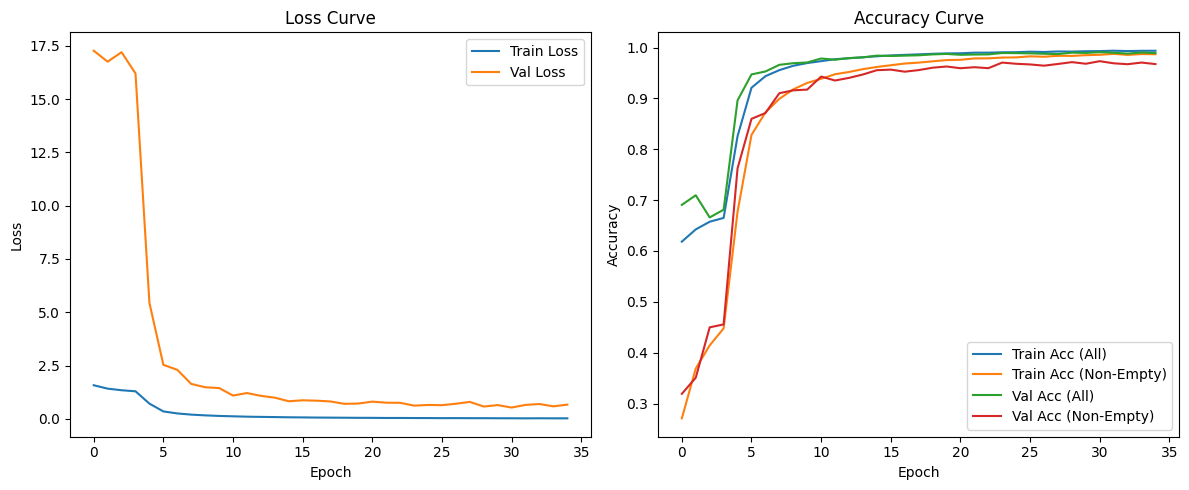

In [ ]:
model = CustomChessCNN_v3(num_classes=13, dropout=0.3)  # or whatever class you used
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/APS360/Project/customV5-residuals-dropout-chessred-full/epoch35.pth"))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

total_params = sum(p.numel() for p in model.parameters())

In [ ]:
print(total_params)

result: 11032525


In [ ]:
from tqdm.notebook import tqdm
evaluate_rotation_invariant(model, test_loader_plain, device=device)

📊 Validation Loss: 0.6391
✅ Accuracy (all squares): 0.9893
♟️ Accuracy (non-empty squares only): 0.9711

🧮 Board-level prediction accuracy (errors per board):
  
  Boards with  0 wrong squares: 1145

  Boards with  1 wrong squares: 405
  
  Boards with  2 wrong squares: 135
  
  Boards with  3 wrong squares: 59
  
  Boards with  4 wrong squares: 16
  
  Boards with  5 wrong squares: 10
  
  Boards with  6 wrong squares: 8
  
  Boards with  7 wrong squares: 2
  
  Boards with  8 wrong squares: 2
  
  Boards with  9 wrong squares: 1
  
  Boards with 10 wrong squares: 2
  
  Boards with 13 wrong squares: 1
  
  Boards with 31 wrong squares: 1
  
  Boards with 33 wrong squares: 1
  
  Boards with 35 wrong squares: 1
  
  Boards with 37 wrong squares: 1
